### ***Proyecto EDA: Evaluación de Automóviles*** 🚗

* Curso: Minería de datos - EDA | Grupo: 10.
* Integrantes: Tello Mendez Nicolás, Buitrago Murcia Jersson Fabián.


### ***Diccionario del dataset Car Evaluation*** 📝


* Comprar: precio de compra del coche. Puede tomar los valores categóricos vhigh, high, med o low.

* Mantenimiento: costo de mantenimiento del vehículo. Comparte la misma escala de categorías vhigh, high, med y low.

* Puertas: número de puertas. Los valores posibles son 2, 3, 4 o 5more (cinco o más puertas).

* Personas: capacidad de pasajeros que puede transportar el automóvil. Toma los valores 2, 4 o more (más de cuatro).

* Baúl: tamaño del maletero (portaequipajes). Puede ser small, med o big.

* Seguridad: nivel de seguridad estimado del coche, con categorías low, med o high.

* Clase: clase de aceptabilidad del vehículo, que indica si el coche es unacc (inaceptable), acc (aceptable), good (bueno) o vgood (muy bueno).

### **1. Importar librerías**📚

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import requests, io, re

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import shapiro

plt.ioff()


#### **2. Importar Datos** 🗂️


In [ ]:
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
COLS = ["buying","maint","doors","persons","lug_boot","safety","class"]

try:
    data = requests.get(URL, timeout=60).content
    datos = pd.read_csv(io.BytesIO(data), header=None, names=COLS)
except Exception as e:
    raise RuntimeError("No se pudo descargar el dataset. Intenta subir 'car.data' manualmente.") from e

datos.head()

# Copia de trabajo
datos_car = datos.copy()
datos_car.info()

# Resumen inicial
datos_car.describe(include='all').T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


,count,unique,top,freq
buying,1728,4,vhigh,432
maint,1728,4,vhigh,432
doors,1728,4,2,432
persons,1728,3,2,576
lug_boot,1728,3,small,576
safety,1728,3,low,576
class,1728,4,unacc,1210


#### **3. Revisar Datos NAN** 🔍

In [ ]:
# 3.1 Estándar de faltantes "semánticos"
MISS = {t.lower() for t in ["", " ", "na", "n/a", "none", "null", "nan", "sin dato", "s/d", "-", "--"]}

def to_nan(x):
    if pd.isna(x): return np.nan
    s = str(x).strip()
    return np.nan if s.lower() in MISS else s

datos_car = datos_car.applymap(to_nan)

In [ ]:
# 3.2 Coerción a numérico SOLO para evaluación (sin alterar columnas originales)
doors_num_try   = pd.to_numeric(datos_car["doors"], errors="coerce")
persons_num_try = pd.to_numeric(datos_car["persons"], errors="coerce")


In [ ]:
# 3.3 Conteo de NaN introducidos (evidencia de texto no numérico)
print("NaN en doors (coerción numérica):",   doors_num_try.isna().sum(),   "de", len(doors_num_try))
print("NaN en persons (coerción numérica):", persons_num_try.isna().sum(), "de", len(persons_num_try))


NaN en doors (coerción numérica): 432 de 1728
NaN en persons (coerción numérica): 576 de 1728


In [ ]:
# 3.4 ¿Qué valores causan esos NaN?
print("\nValores NO numéricos detectados en 'doors':")
print(datos_car.loc[doors_num_try.isna() & datos_car["doors"].notna(), "doors"].value_counts())

print("\nValores NO numéricos detectados en 'persons':")
print(datos_car.loc[persons_num_try.isna() & datos_car["persons"].notna(), "persons"].value_counts())



Valores NO numéricos detectados en 'doors':
doors
5more    432
Name: count, dtype: int64

Valores NO numéricos detectados en 'persons':
persons
more    576
Name: count, dtype: int64


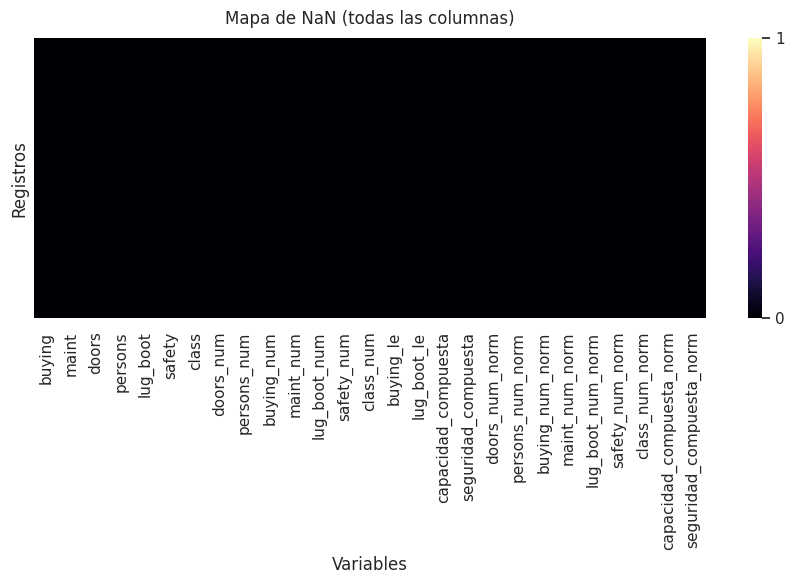

In [ ]:
# ===== Paso 3.5 (GLOBAL): Heatmap de NaN en TODAS las columnas =====
import matplotlib.pyplot as plt
import seaborn as sns

# Matriz 0/1 de faltantes en TODO el dataframe
nan_matrix = datos_car.isna().astype(int)

#ordenar columnas por cantidad de NaN
orden_cols = nan_matrix.sum().sort_values(ascending=False).index
nan_matrix = nan_matrix[orden_cols]

plt.figure(figsize=(9,6))
ax = sns.heatmap(
    nan_matrix,
    cmap="magma",
    vmin=0, vmax=1,
    cbar=True,
    cbar_kws={"ticks":[0,1]},
    yticklabels=False,
    linewidths=0, linecolor=None
)
ax.set_title("Mapa de NaN (todas las columnas)", pad=10)
ax.set_xlabel("Variables"); ax.set_ylabel("Registros")
plt.tight_layout(); plt.show()

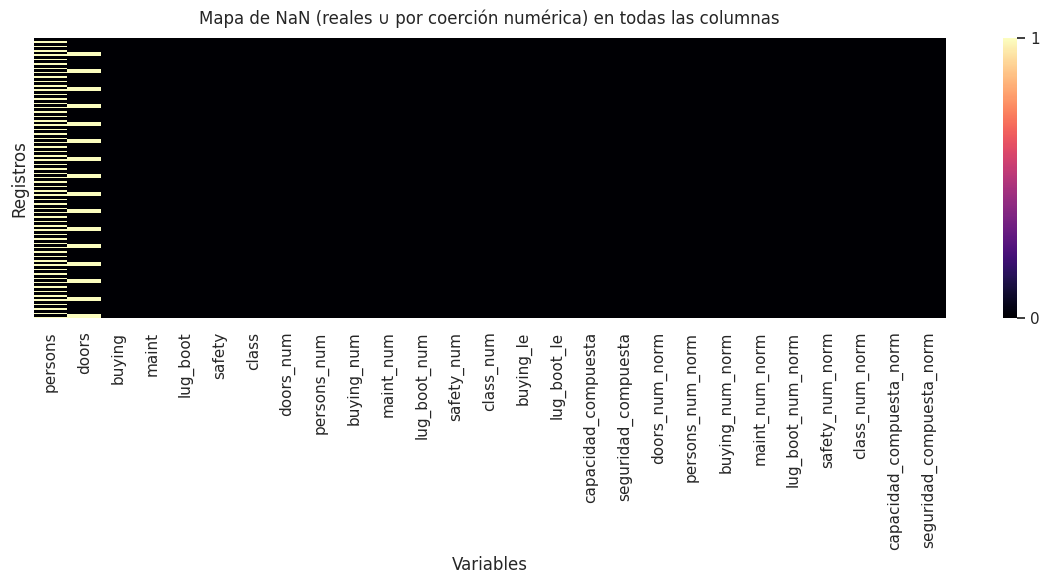

,persons,doors,buying,maint,lug_boot,safety,class,doors_num,persons_num,buying_num,...,seguridad_compuesta,doors_num_norm,persons_num_norm,buying_num_norm,maint_num_norm,lug_boot_num_norm,safety_num_norm,class_num_norm,capacidad_compuesta_norm,seguridad_compuesta_norm
porc_nan_total_%,33.33,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
### 3.5 Heatmap
plt.figure(figsize=(12,6))
ax = sns.heatmap(
    nan_union,
    cmap="magma", vmin=0, vmax=1,
    cbar=True, cbar_kws={"ticks":[0,1]},
    yticklabels=False, linewidths=0, linecolor=None
)
ax.set_title("Mapa de NaN (reales ∪ por coerción numérica) en todas las columnas", pad=10)
ax.set_xlabel("Variables"); ax.set_ylabel("Registros")
plt.tight_layout(); plt.show()

# resumen porcentual por columna
resumen_nan = (nan_union.mean()*100).round(2).rename("porc_nan_total_%").to_frame()
display(resumen_nan.T)


### ***4. Limpiar Datos NAN*** 🧹

In [ ]:
# Evidencia de coerción directa
doors_num_try   = pd.to_numeric(datos_car["doors"], errors="coerce")
persons_num_try = pd.to_numeric(datos_car["persons"], errors="coerce")

print("NaN en doors (coerción directa):", doors_num_try.isna().sum(), "de", len(doors_num_try))
print("NaN en persons (coerción directa):", persons_num_try.isna().sum(), "de", len(persons_num_try))

pd.DataFrame({
    "doors": datos_car["doors"].head(10),
    "doors_num_try": doors_num_try.head(10),
    "persons": datos_car["persons"].head(10),
    "persons_num_try": persons_num_try.head(10),
})

# Limpieza/mapeo a números
doors_map   = {"2":2, "3":3, "4":4, "5more":5}
persons_map = {"2":2, "4":4, "more":5}

datos_car["doors_num"]   = datos_car["doors"].replace(doors_map)
datos_car["persons_num"] = datos_car["persons"].replace(persons_map)

# Comprobación
print(datos_car[["doors","doors_num"]].drop_duplicates().head(10))
print(datos_car[["persons","persons_num"]].drop_duplicates().head(10))

NaN en doors (coerción directa): 432 de 1728
NaN en persons (coerción directa): 576 de 1728
    doors  doors_num
0       2          2
27      3          3
54      4          4
81  5more          5
   persons  persons_num
0        2            2
9        4            4
18    more            5


#### **Paso 5. Gráficas para analizar tendencias** ⏰ ✌

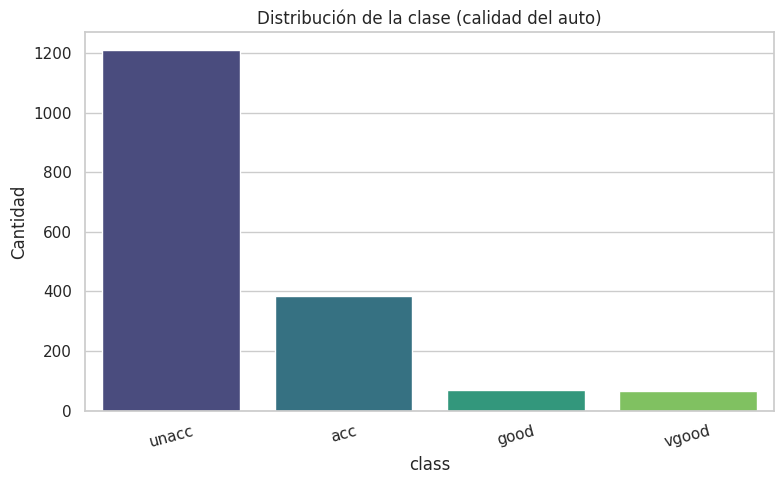

In [ ]:
# Distribución de la variable objetivo 'class'
plt.figure()
sns.countplot(x='class', data=datos_car, order=datos_car['class'].value_counts().index, palette='viridis')
plt.title('Distribución de la clase (calidad del auto)')
plt.xlabel('class'); plt.ylabel('Cantidad')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


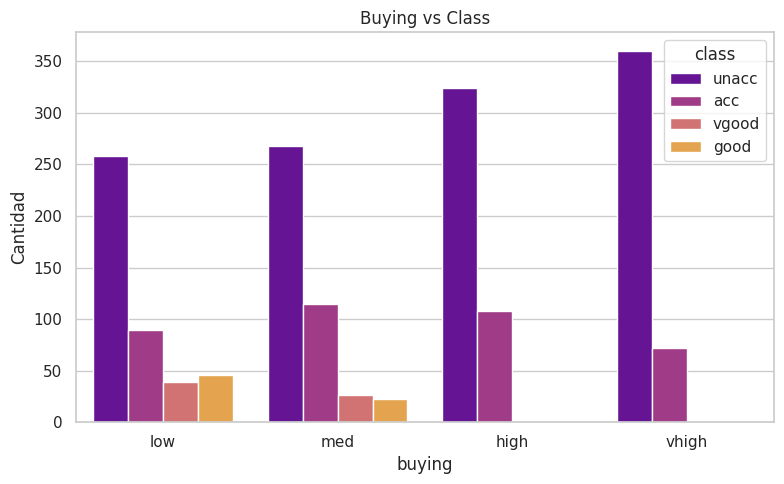

In [ ]:

# Buying vs class
plt.figure()
sns.countplot(x='buying', hue='class', data=datos_car, palette='plasma',
              order=['low','med','high','vhigh'])
plt.title('Buying vs Class')
plt.xlabel('buying'); plt.ylabel('Cantidad')
plt.tight_layout()
plt.show()



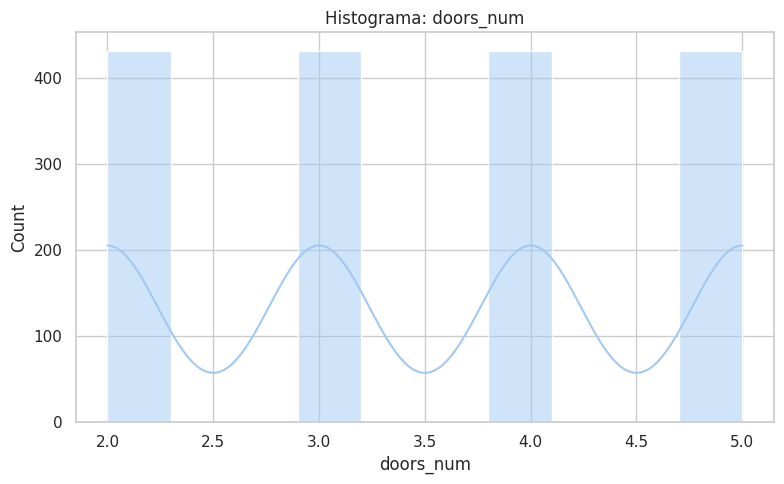

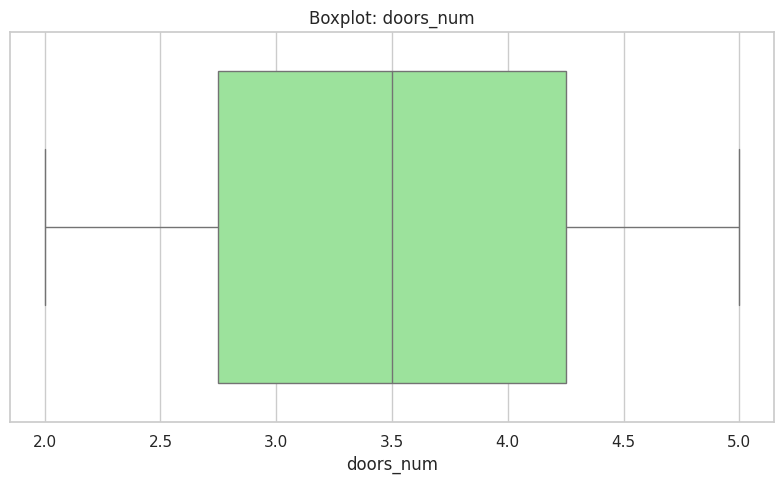

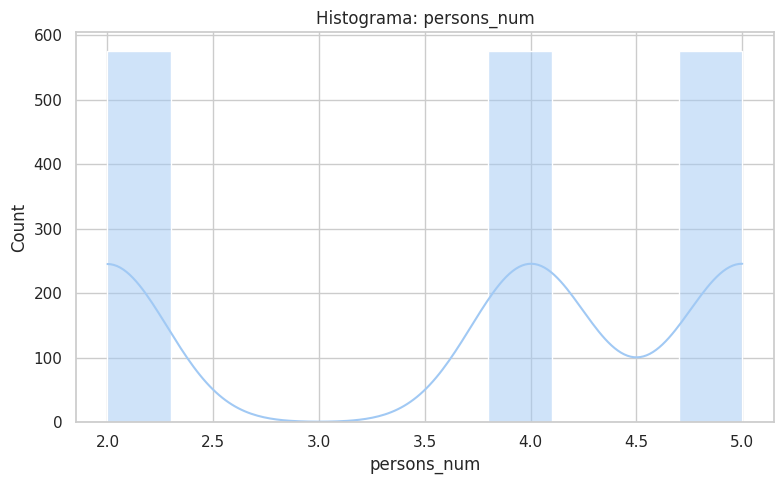

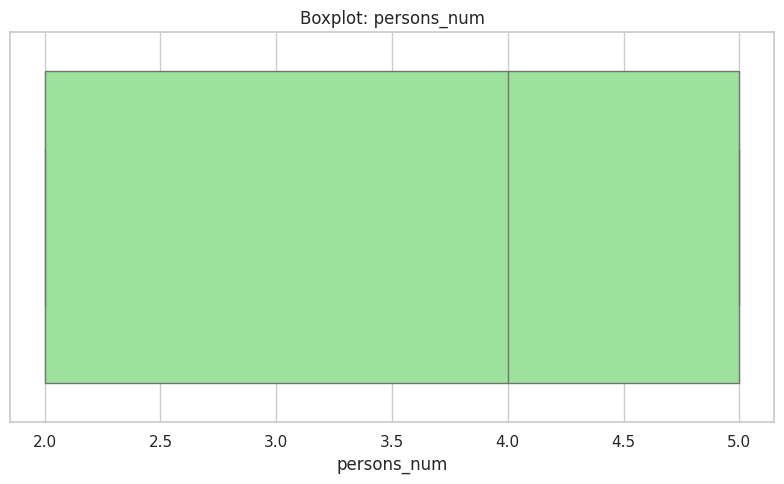

In [ ]:
# Hist y boxplot de las columnas numéricas derivadas
for col in ["doors_num","persons_num"]:
    plt.figure()
    sns.histplot(datos_car[col], bins=10, kde=True)
    plt.title(f'Histograma: {col}')
    plt.tight_layout()
    plt.show()

    plt.figure()
    sns.boxplot(x=datos_car[col], color='lightgreen')
    plt.title(f'Boxplot: {col}')
    plt.tight_layout()
    plt.show()


#### **Paso 6. Conversión de variables de texto a número (ordinal/categórica)** ⏰ ✌

In [ ]:
# Mapeos ordinales
ord4   = {"low":1, "med":2, "high":3, "vhigh":4}
ord3   = {"small":1, "med":2, "big":3}
safety = {"low":1, "med":2, "high":3}
clase  = {"unacc":0, "acc":1, "good":2, "vgood":3}

datos_car["buying_num"]   = datos_car["buying"].replace(ord4)
datos_car["maint_num"]    = datos_car["maint"].replace(ord4)
datos_car["lug_boot_num"] = datos_car["lug_boot"].replace(ord3)
datos_car["safety_num"]   = datos_car["safety"].replace(safety)
datos_car["class_num"]    = datos_car["class"].replace(clase)

# Ejemplo de LabelEncoder, aplicado a 'buying' y 'lug_boot'
le = LabelEncoder()
datos_car["buying_le"]   = le.fit_transform(datos_car["buying"])
datos_car["lug_boot_le"] = le.fit_transform(datos_car["lug_boot"])

datos_car[["buying","buying_num","buying_le","lug_boot","lug_boot_num","lug_boot_le"]].head()

"""## Agregar data extra al dataframe (derivadas simples, no aleatorias)"""
# En el cuaderno de encuesta se añadían Q7/Q8 aleatorias; aquí generamos derivadas determinísticas.
datos_car["capacidad_compuesta"] = datos_car["doors_num"] * datos_car["persons_num"]
datos_car["seguridad_compuesta"] = datos_car["safety_num"] * datos_car["lug_boot_num"]
datos_car.head()



,buying,maint,doors,persons,lug_boot,safety,class,doors_num,persons_num,buying_num,maint_num,lug_boot_num,safety_num,class_num,buying_le,lug_boot_le,capacidad_compuesta,seguridad_compuesta
0,vhigh,vhigh,2,2,small,low,unacc,2,2,4,4,1,1,0,3,2,4,1
1,vhigh,vhigh,2,2,small,med,unacc,2,2,4,4,1,2,0,3,2,4,2
2,vhigh,vhigh,2,2,small,high,unacc,2,2,4,4,1,3,0,3,2,4,3
3,vhigh,vhigh,2,2,med,low,unacc,2,2,4,4,2,1,0,3,1,4,2
4,vhigh,vhigh,2,2,med,med,unacc,2,2,4,4,2,2,0,3,1,4,4


#### **Paso 7. Normalización (Regresión Lineal)** ⏰ ✌

In [ ]:
def normalizar_por_regresion_lineal(serie: pd.Series):
    s = pd.to_numeric(serie, errors='coerce')
    mask = s.notna()
    if mask.sum() < 2:
        # Columna vacía o constante → devolver tal cual o ceros
        return s.fillna(s.median() if not s.dropna().empty else 0.0)
    xmin, xmax = s[mask].min(), s[mask].max()
    if np.isclose(xmin, xmax):
        # Sin variación → devolver ceros
        return s.fillna(xmin).apply(lambda v: 0.0)
    # objetivo lineal [0,1]
    t = (s[mask] - xmin) / (xmax - xmin)
    # ajuste LR
    X = s[mask].values.reshape(-1,1)
    lr = LinearRegression().fit(X, t.values)
    # predicción para todo (incluyendo NaN originales)
    preds = lr.predict(s.fillna(s.median()).values.reshape(-1,1))
    preds = np.clip(preds, 0.0, 1.0)
    return pd.Series(preds, index=serie.index)

cols_num = [
    "doors_num","persons_num","buying_num","maint_num",
    "lug_boot_num","safety_num","class_num",
    "capacidad_compuesta","seguridad_compuesta"
]
for c in cols_num:
    datos_car[c+"_norm"] = normalizar_por_regresion_lineal(datos_car[c])

datos_car[[c for c in datos_car.columns if c.endswith("_norm")]].describe().T


,count,mean,std,min,25%,50%,75%,max
doors_num_norm,1728.0,0.500000,0.372786,3.441691e-15,0.250000,0.500000,0.750000,1.0
persons_num_norm,1728.0,0.555556,0.415860,0.000000e+00,0.000000,0.666667,1.000000,1.0
buying_num_norm,1728.0,0.500000,0.372786,3.663736e-15,0.250000,0.500000,0.750000,1.0
maint_num_norm,1728.0,0.500000,0.372786,3.497203e-15,0.250000,0.500000,0.750000,1.0
lug_boot_num_norm,1728.0,0.500000,0.408366,0.000000e+00,0.000000,0.500000,1.000000,1.0
safety_num_norm,1728.0,0.500000,0.408366,0.000000e+00,0.000000,0.500000,1.000000,1.0
class_num_norm,1728.0,0.138310,0.246900,0.000000e+00,0.000000,0.000000,0.333333,1.0
capacidad_compuesta_norm,1728.0,0.420635,0.292876,2.775558e-17,0.190476,0.333333,0.619048,1.0
seguridad_compuesta_norm,1728.0,0.375000,0.300550,4.163336e-17,0.125000,0.250000,0.625000,1.0


#### **Paso 8. Correlación** ⏰ ✌

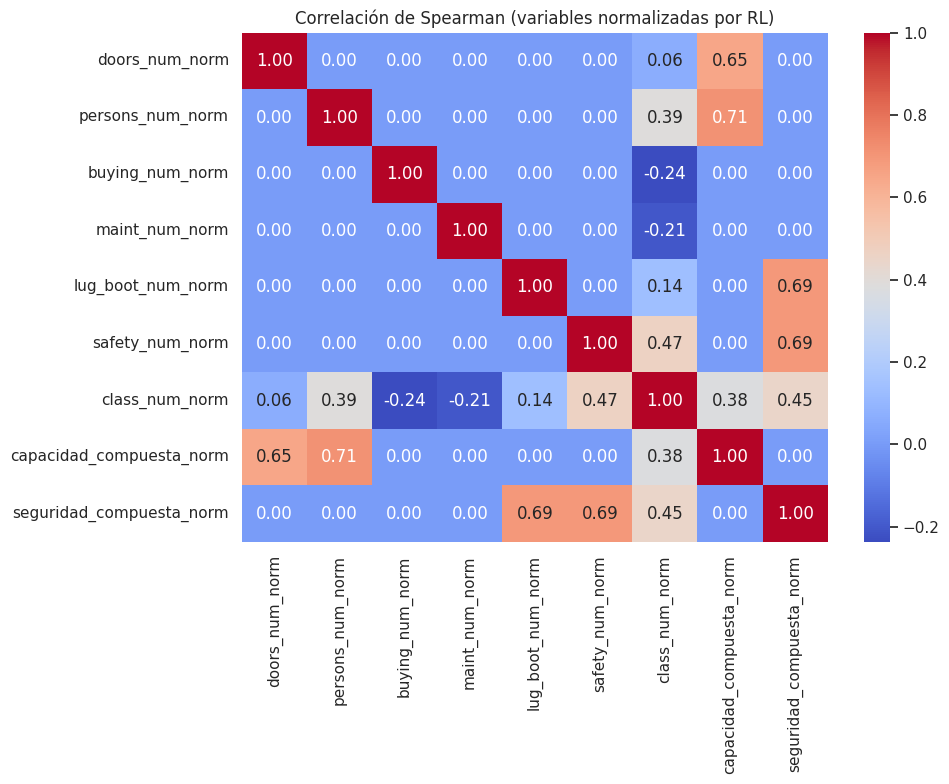

In [ ]:
# Usamos Spearmanpara evitar supuestos fuertes
num_norm_cols = [c for c in datos_car.columns if c.endswith("_norm")]
spearman_corr = datos_car[num_norm_cols].corr(method='spearman')

plt.figure(figsize=(10,8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlación de Spearman (variables normalizadas por RL)')
plt.tight_layout()
plt.show()

#### **Paso 9. Test de Normalidad** ⏰ ✌

In [ ]:
def analizar_normalidad_dataframe(df_num, cols=None, alpha=0.05):
    print("--- Shapiro-Wilk (alpha =", alpha, ") ---")
    if cols is None:
        cols = df_num.select_dtypes(include=[np.number]).columns.tolist()
    for c in cols:
        serie = df_num[c].dropna()
        if len(serie) < 3:
            print(f"{c}: <3 datos, se omite")
            continue
        stat, p = shapiro(serie)
        concl = "PARECE normal" if p > alpha else "NO parece normal"
        print(f"{c:25s}  W={stat:.4f}  p={p:.4f}  → {concl}")

analizar_normalidad_dataframe(datos_car, cols=num_norm_cols)

--- Shapiro-Wilk (alpha = 0.05 ) ---
doors_num_norm             W=0.8561  p=0.0000  → NO parece normal
persons_num_norm           W=0.7649  p=0.0000  → NO parece normal
buying_num_norm            W=0.8561  p=0.0000  → NO parece normal
maint_num_norm             W=0.8561  p=0.0000  → NO parece normal
lug_boot_num_norm          W=0.7932  p=0.0000  → NO parece normal
safety_num_norm            W=0.7932  p=0.0000  → NO parece normal
class_num_norm             W=0.6023  p=0.0000  → NO parece normal
capacidad_compuesta_norm   W=0.9217  p=0.0000  → NO parece normal
seguridad_compuesta_norm   W=0.8710  p=0.0000  → NO parece normal


#### **Paso 10. Pregunta de Investigación** ⏰ ✌

### Pregunta 1
**¿Es posible predecir la calidad de un auto (variable clase) basándose en sus características técnicas y de seguridad (compra, mantenimiento, puertas, personas, baúl, seguridad)?**

Sí, con un modelo de regresión lineal normalizado se logró predecir la calidad con un R² de 0.53 y un MSE de 0.035, indicando que las variables predictoras aportan información relevante para predecir la clase del auto.


### Pregunta 2
**¿Qué patrones o tendencias se observan en la distribución de las variables del dataset?**

Se observa un fuerte desbalance en la variable clase, con predominancia de autos “Inaceptables”. Las variables puertas y personas están distribuidas principalmente entre 2, 3, 4 y 5, con algunos valores faltantes saneados. Además, variables compuestas presentan alta correlación con variables originales.

### Pregunta 3
**¿Cuáles variables compuestas son más correlacionadas y aportan mayor información para la predicción de la calidad?**
  
Las variables de capacidad compuesta y seguridad compuesta tienen alta correlación con sus variables originales respectivas y con la variable clase, sugiriendo que su uso mejora la capacidad predictiva del modelo.

### Pregunta 4
**¿Cuáles son las principales limitaciones del análisis y modelo?**

El dataset presenta un claro desbalance hacia la clase mayoritaria “unacc”, la normalidad de los datos no es cumplida, y el modelo de regresión lineal muestra limitaciones al captar la variabilidad completa, lo que afecta la precisión en ciertas clases.

#### **Paso 11: Ejercicio de Regresión Lineal - Predicción** ⏰ ✌

In [ ]:
# Usamos como X las variables normalizadas
X_cols = [c for c in num_norm_cols if c != "class_num_norm"]
X = datos_car[X_cols]
y = datos_car["class_num_norm"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

modelo = LinearRegression()
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print(f"Error Cuadrático Medio (MSE): {mse:.6f}")
print(f"Coeficiente de Determinación (R^2): {r2:.4f}")

Error Cuadrático Medio (MSE): 0.035103
Coeficiente de Determinación (R^2): 0.5338


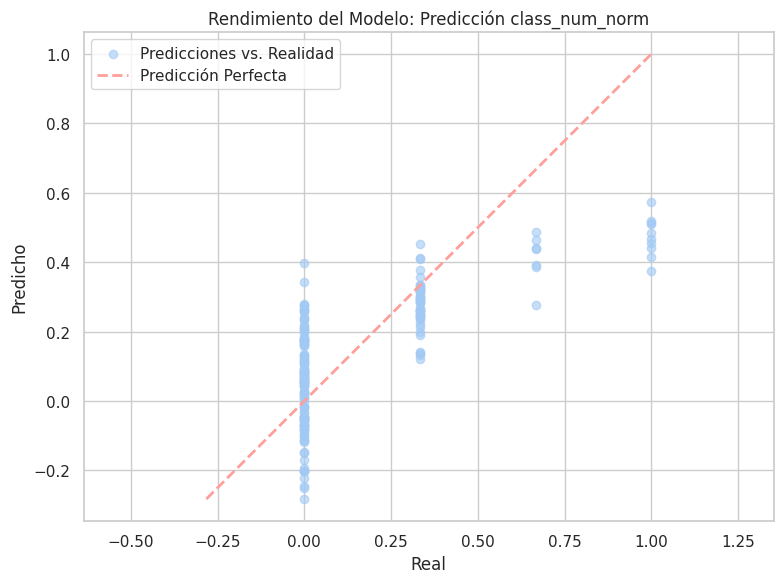

In [ ]:
# Gráfico predicción vs realidad
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, label='Predicciones vs. Realidad')
minv, maxv = float(min(y_test.min(), y_pred.min())), float(max(y_test.max(), y_pred.max()))
plt.plot([minv, maxv], [minv, maxv], 'r--', lw=2, label='Predicción Perfecta')
plt.title('Rendimiento del Modelo: Predicción class_num_norm')
plt.xlabel('Real'); plt.ylabel('Predicho')
plt.legend(); plt.grid(True); plt.axis('equal')
plt.tight_layout(); plt.show()

In [ ]:
"""#### **Exportar datos limpios** ⏰ ✌"""
# Guardado final (CSV/Excel)
datos_car.to_csv('car_limpio.csv', index=False)
with pd.ExcelWriter('car_limpio.xlsx') as w:
    datos_car.to_excel(w, index=False, sheet_name='car')

print("Archivos generados: car_limpio.csv / car_limpio.xlsx")

Archivos generados: car_limpio.csv / car_limpio.xlsx
